# Open Source Operational Energy Yield Analysis (Oh SOe YeAh)

This python notebook demonstrates the use of the osoeya package to calculate the long-term generation of an asset using historical operational data and resource data.

## Next steps
1. DONE - Rename columns as required
1. DONE - Column definitions
1. DONE - add plot to review long-term reference windspeeds
1. DONE - improved merra2 downloader to more rapidly check available files

## Improvements
These are not listed in any particular order at the moment.

### Data
1. PARTIAL - EIA download for all plants to speed up results
1. Cover wind and solar
1. Link to OSM to get turbine level layout
1. Update information on wikidata
1. Reporting dodgy data
1. Check EIA asset capacity has not changed over time
1. Extend to other open generation datasets (e.g. UK, Europe, Australia, Brazil)
1. Comparison of additional resource nodes (e.g. nearest 9) for best correlation

### Methodology
1. Review other fits: https://realpython.com/linear-regression-in-python/
1. Degradation analysis (important for solar)
1. Time-series analysis to check data consistency
1. Validation
1. Fringe case of no data in a given month - utilise synthesised data instead
1. Ability for manual inputs of generation and availability

### Usability
1. Simple front-end
1. Map of assets covered
1. Examples
1. Documentation
1. Prettify results :)
1. Web-app
1. Add logging and remove some of the print outputs

## Methodology

The methodology is typical of that used by the industry, with a Measure, Correlate, Predict (MCP) approach adopted, and using the predictions to apply a long-term resource adjustment to the reported generations on a monthly basis, using a Mean of Monthly Means (momm). This ensures the long-term generation estimate accounts for the resource over the period of review compared to the long-term, while also maintaining the correct seasonality.

1. Load the required libraries and environment variables
1. Get the generation and long-term resource data
1. Filter the data to remove any months that are unrepresentative of the long-term
1. Normalise the data
1. Select the best correlating resource dataset
1. Filter the data to remove any months from the correlation that are strong outliers
1. Take the Mean of Monthly Means (momm)
1. Calculate the long-term adjustment required for each month
1. Calculate the long-term generation and availability for each month
1. Calculate the annual long-term generation and availability
1. Save the results to excel




### Definitions

#### Signals

In [1]:
# define and list signals used

signal_dict = {
     "windspeed-era5":"the long-term reference wind speed using the ERA5 reanalysis dataset normalised by the average wind speed (e.g. wind-speed/long-term-mean-wind-speed)",
     "windspeed-merra2":"the long-term reference wind speed using the MERRA2 reanalysis dataset normalised by the average wind speed (e.g. wind-speed/long-term-mean-wind-speed)",
     "windspeed-index":"the long-term reference wind speed calculated as the average of windspeed-era5 and windspeed-merra2",
     "generation":"monthly net generation at the meter",
     "gross-generation":"monthly gross generation (e.g. at 100% availability)",
     "month":"the number of the month (i.e. 1=January, 12=December)",
     "days-in-month":"the number of days in the month (e.g. Jan=31, Feb=28 or 29)",
     "availability-reported":"the system availability of the plant (e.g. generation/gross-generation)",
     "exclude-from-long-term":"any months excluded from the long-term forecast, because they are unrepresentative (e.g. one-off non-recurring exceptional events)",
     "generation-filtered":"the generation filtered of any exceptional events (e.g. based on the exclude-from-long-term flag",
     "gross-generation-filtered":"the gross-generation filtered of any exceptional events (e.g. one-off non-recurring outages)",
     "generation-normalised":"the gross-generation normalised to 30-day periods",
     "windspeed":"the selected long-term reference wind speed for use in the long-term resource adjustment calculation",
     "concurrent-generation-normalised":"the generation-normalised where there is windspeed data available",
     "concurrent-windspeed":"the windspeed where generation-normalised data is available",
     "concurrent-generation-synthesised-with-outliers":"synthesised generation using all concurrent data for the linear fit",
     "residuals":"comparison between concurrent-generation-synthesised-with-outliers and concurrent-generation-normalised to identify outliers",
     "correlation-outlier":"flag to identify any data points which are outliers, based on being greater than 3-standard-deviations from the average of the residuals",
     "concurrent-generation-normalised-filtered":"the concurrent-generation-normalised with the correlation-outlier filter applied",
     "concurrent-windspeed-filtered":"the concurrent-windspeed filtered for the same outliers as the concurrent-generation-normalised-filtered",
     "generation-synthesised":"the synthesised generation based on the windspeed and a linear regression of the concurrent-generation-normalised-filtered and concurrent-windspeed-filtered",
     "concurrent-generation-synthesised":"the synthesised generation based on the concurrent-windspeed-filtered and a linear regression of the concurrent-generation-normalised-filtered and concurrent-windspeed-filtered",
     }

for key in signal_dict:
     print(f"{key} : {signal_dict[key]}")

windspeed-era5 : the long-term reference wind speed using the ERA5 reanalysis dataset normalised by the average wind speed (e.g. wind-speed/long-term-mean-wind-speed)
windspeed-merra2 : the long-term reference wind speed using the MERRA2 reanalysis dataset normalised by the average wind speed (e.g. wind-speed/long-term-mean-wind-speed)
windspeed-index : the long-term reference wind speed calculated as the average of windspeed-era5 and windspeed-merra2
generation : monthly net generation at the meter
gross-generation : monthly gross generation (e.g. at 100% availability)
month : the number of the month (i.e. 1=January, 12=December)
days-in-month : the number of days in the month (e.g. Jan=31, Feb=28 or 29)
availability-reported : the system availability of the plant (e.g. generation/gross-generation)
exclude-from-long-term : any months excluded from the long-term forecast, because they are unrepresentative (e.g. one-off non-recurring exceptional events)
generation-filtered : the generat

#### Other
1. Mean of monthly mean (momm) - averaging together all months of the same name (e.g. mean of all January's, February's, etc.)
1. P50 - the median long-term expectations, with a 50% chance of being higher or lower
1. Measure Correlate Predict (MCP) - a method to predict long-term values from a shorter period of measurements, by correlating the shorter period of measurements to a long-term reference dataset, then using the (typically linear) fit to predict the values over the long-term using the long-term reference dataset


## Load libraries and environment variables

For downloading the ERA5 resource data from the CDS registration is required. Please see instructions for registration and setting up the API here: https://cds.climate.copernicus.eu/api-how-to

For downloading the EIA plant generation data registration is required. See here: https://www.eia.gov/opendata/register.php. The API password should then be added to a .env text file in the main OSOEYA directory as follows: EIA_API_KEY = "xxxx"

In [2]:
# load system packages
import os
from pathlib import Path

# load custom packages (requirements)
import pandas as pd
import matplotlib.pyplot as plt

# load functions from packages (also requirements)
from dotenv import load_dotenv
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from scipy import stats
from bokeh.io import show, output_notebook
output_notebook()

# load local package functions
from downloader import get_era5_monthly, get_merra2_monthly, get_EIA_plant_information, get_EIA_plant_generation
from plot import plot_assets

# load environment variables
load_dotenv()
EIA_API_KEY = os.environ["EIA_API_KEY"]


Loading BokehJS ...

## Load data

This codes 
1. Gets EIA plant information
1. Allows the user to select a plant for review
1. Downloads the EIA generation data for that asset
1. Downloads and accesses the long-term ERA5 resource data for the asset

The first time this code is run this will take a while, as it downloads a significant amount of data (~500MB for ERA5), for local storage and future rapid access.

In [3]:
# get EIA plant information for wind assets
plant_info_file=Path("data/plant_list.csv").resolve()
if not plant_info_file.is_file():
    df_plant = get_EIA_plant_information(EIA_API_KEY)
    df_plant.to_csv(plant_info_file)
else:
    df_plant = pd.read_csv(plant_info_file)

df_plant['country'] = 'USA'
df_plant['dataSource'] = 'IEA'

df_plant[[
       'country',
       'stateName',
       'plantName',
       'plantid',
       ]].head(20)

df_plant = df_plant.rename(columns={"nameplate-capacity-mw":"nameplateCapacityMW","operating-year-month":"operatingYearMonth"})



In [4]:
# select an EIA plant for analysis
selected_plant = df_plant.iloc[10]
print(selected_plant[[
       'plantName',
       'technology',
       'nameplateCapacityMW', 
       'operatingYearMonth', 
       'statusDescription',
       'longitude', 
       'latitude',
       'dataSource',
       ]])

plantName                       Baffin Wind
technology             Onshore Wind Turbine
nameplateCapacityMW                   188.0
operatingYearMonth                  2014-12
statusDescription                 Operating
longitude                         -97.59818
latitude                          27.184652
dataSource                              IEA
Name: 10, dtype: object


In [5]:
p_assets = plot_assets(df_plant,selected_plant)

show(p_assets)

In [6]:
# get the EIA generation for the selected plant

plant_data_file = Path(f"data/plant_generation_{selected_plant['plantid']}.csv").resolve()

if not plant_data_file.is_file():
    df_generation = get_EIA_plant_generation(EIA_API_KEY,plantCode=selected_plant["plantid"])
    df_generation.to_csv(plant_data_file)

else:
    df_generation = pd.read_csv(plant_data_file)

# set index to converted datetime
df_generation = df_generation.set_index("period")
df_generation.index = pd.to_datetime(df_generation.index)

print(df_generation[['generation','gross-generation']])

            generation  gross-generation
period                                  
2021-12-01    42444.74          42569.28
2021-11-01    37371.32          37480.97
2021-10-01    38286.62          38398.96
2021-09-01    30741.84          30832.04
2021-08-01    32423.40          32518.54
...                ...               ...
2015-05-01    48023.00          48023.00
2015-04-01    28384.00          28384.00
2015-03-01    19142.00          19142.00
2015-02-01     4482.00           4482.00
2015-01-01        0.00              0.00

[84 rows x 2 columns]


In [7]:
# get era5 data for the selected plant
df_era5 = get_era5_monthly(
    lat=selected_plant["latitude"],
    lon=selected_plant["longitude"]%360,
    save_pathname="data",
    save_filename=f"era5_monthly_plant_{selected_plant['plantid']}",
    data_pathname="data/era5_monthly",
    data_filename="era5_monthly",
    start_date="2000-01",
)

df_era5 = df_era5.rename(columns={"windspeed_ms": "windspeed-era5"})

print(df_era5)

            windspeed-era5
datetime                  
2000-01-01        4.676200
2000-02-01        5.311403
2000-03-01        5.242496
2000-04-01        5.158672
2000-05-01        6.019043
...                    ...
2023-04-01        4.935527
2023-05-01        3.917282
2023-06-01        5.146538
2023-07-01        4.979041
2023-08-01        4.541347

[284 rows x 1 columns]


In [8]:
# get merra2 data for the selected plant
df_merra2 = get_merra2_monthly(
    lat=selected_plant["latitude"],
    lon=selected_plant["longitude"]%360,
    save_pathname="data",
    save_filename=f"merra2_monthly_plant_{selected_plant['plantid']}",
    data_pathname="data/merra2_monthly",
    data_filename="merra2_monthly",
    start_date="2000-01",
)

df_merra2 = df_merra2.rename(columns={"windspeed_ms": "windspeed-merra2"})

print(df_merra2)

            windspeed-merra2
datetime                    
2000-01-01          7.563000
2000-02-01          8.325962
2000-03-01          8.015005
2000-04-01          7.611416
2000-05-01          8.481580
...                      ...
2023-04-01          7.120168
2023-05-01          5.675215
2023-06-01          7.051120
2023-07-01          6.727225
2023-08-01          6.016686

[284 rows x 1 columns]


In [9]:
# create a resource dataset consisting of the long-term reference datasets
df_resource = pd.concat([df_era5[["windspeed-era5"]],df_merra2[["windspeed-merra2"]]],axis=1)

# normalise the wind speed references
df_resource = df_resource/df_resource.mean()

# create an index of era5 and merra2
df_resource["windspeed-index"] = (df_resource["windspeed-era5"]+df_resource["windspeed-merra2"])/2

df_resource

,windspeed-era5,windspeed-merra2,windspeed-index
datetime,,,
2000-01-01,1.012586,1.059147,1.035866
2000-02-01,1.150133,1.165995,1.158064
2000-03-01,1.135211,1.122447,1.128829
2000-04-01,1.117060,1.065927,1.091494
2000-05-01,1.303365,1.187788,1.245577
...,...,...,...
2023-04-01,1.068740,0.997131,1.032936
2023-05-01,0.848249,0.794775,0.821512
2023-06-01,1.114433,0.987462,1.050947


In [10]:
# combine wind speed and generation into single dataframe
df = pd.concat([df_resource[["windspeed-era5","windspeed-merra2","windspeed-index"]],df_generation[["generation","gross-generation"]]],axis=1)

# add month number column
df["month"] = df.index.to_series().dt.month

# add days in month column
df["days-in-month"] = df.index.to_series().dt.days_in_month

# add availability column
df["availability-reported"] = df["generation"]/df["gross-generation"]

## Exclusions from long-term analysis

Where data is not representative of the long-term, it can be manually excluded. For example this could be due to plant ramp up, acts of god, or other rare events that are unlikely to occur in the future.

In [11]:
df["exclude-from-long-term"] = False

# any dates that are not representative of long-term performance can be excluded here
# e.g. df.loc["2014-01-01","exclude-from-long-term"] = True
# df.loc["2014-01-01","exclude-from-long-term"] = True

In [12]:
# add filtered generation column
df["generation-filtered"] = df["generation"][df["exclude-from-long-term"]==False]
df["gross-generation-filtered"] = df["gross-generation"][df["exclude-from-long-term"]==False]

# add normalised generation column
df["generation-normalised"] = df["gross-generation-filtered"]*30/df["days-in-month"]

In [13]:
# pick which long-term resource windspeed to use
df_selector = df[["windspeed-era5","windspeed-merra2","windspeed-index","generation-normalised"]].dropna()

# apply linear fits to the data
res_era5 = stats.linregress(x=df_selector["windspeed-era5"],y=df_selector["generation-normalised"])
res_merra2 = stats.linregress(x=df_selector["windspeed-merra2"],y=df_selector["generation-normalised"])
res_index = stats.linregress(x=df_selector["windspeed-index"],y=df_selector["generation-normalised"])

print(f"ERA5 R-squared: {res_era5.rvalue**2:.6f}")
print(f"MERRA2 R-squared: {res_merra2.rvalue**2:.6f}")
print(f"index R-squared: {res_index.rvalue**2:.6f}")

# compare R-squares and select the best correlating reference for use
if res_merra2.rvalue == max(res_era5.rvalue,res_era5.rvalue,res_era5.rvalue):
    df["windspeed"] = df["windspeed-merra2"]
elif res_era5.rvalue == max(res_era5.rvalue,res_era5.rvalue,res_era5.rvalue):
    df["windspeed"] = df["windspeed-era5"]
else:
    df["windspeed"] = df["windspeed-index"]

# if you want to override with a specific resource, you can do it here
# e.g. df["windspeed"] = df["windspeed-era5"]
# df["windspeed"] = df["windspeed-era5"]


ERA5 R-squared: 0.324773
MERRA2 R-squared: 0.348910
index R-squared: 0.354803


In [14]:

# add concurrent generation normalised column
df["concurrent-generation-normalised"] = df["generation-normalised"][df["windspeed"].notnull() & df["generation-normalised"].notnull()]

# add concurrent windspeed
df["concurrent-windspeed"] = df["windspeed"][df["concurrent-generation-normalised"].notnull()]

print(df.dropna())


            windspeed-era5  windspeed-merra2  windspeed-index  generation  \
2015-02-01        0.944302          0.981955         0.963129     4482.00   
2015-03-01        0.818815          0.890758         0.854787    19142.00   
2015-04-01        0.970356          0.982573         0.976465    28384.00   
2015-05-01        1.211055          1.177433         1.194244    48023.00   
2015-06-01        0.899957          0.953096         0.926527    35878.00   
...                    ...               ...              ...         ...   
2021-08-01        0.863824          0.835504         0.849664    32423.40   
2021-09-01        0.815472          0.798575         0.807024    30741.84   
2021-10-01        0.837881          0.869627         0.853754    38286.62   
2021-11-01        0.839897          0.876064         0.857980    37371.32   
2021-12-01        1.002450          1.006573         1.004511    42444.74   

            gross-generation  month  days-in-month  availability-reported  

<Axes: >

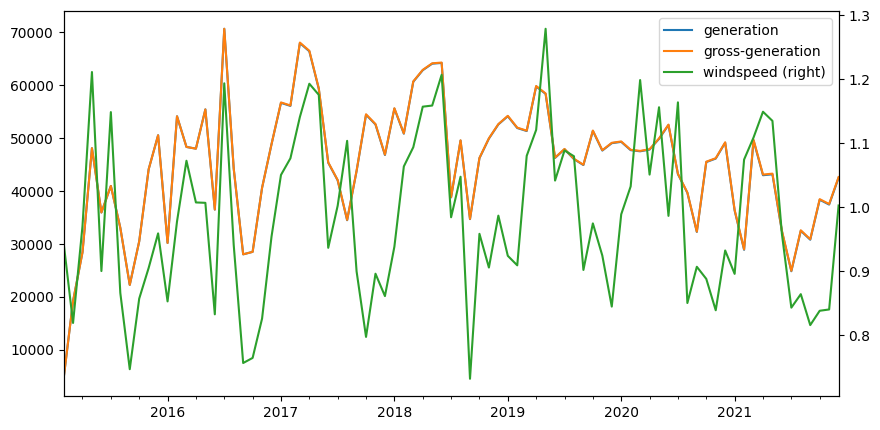

In [15]:
df_plot = df.dropna()
fig, ax = plt.subplots(figsize=(10,5)) 
df_plot.plot(y = "generation", ax = ax) 
df_plot.plot(y = "gross-generation", ax = ax) 
df_plot.plot(y = "windspeed", ax = ax, secondary_y = True) 


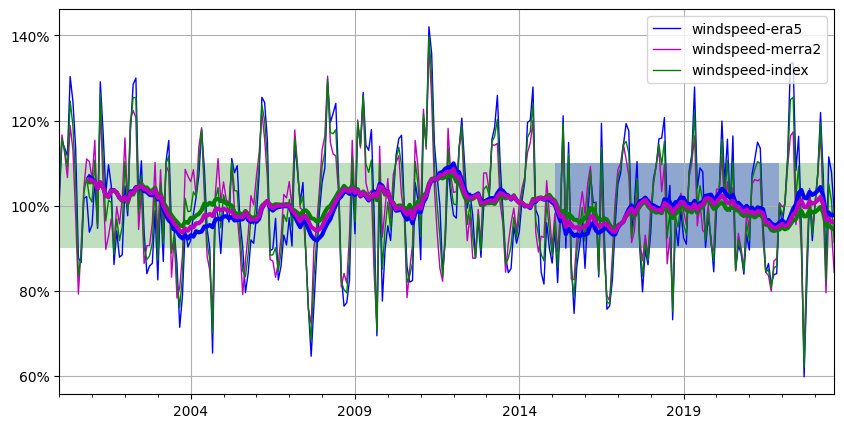

In [16]:
# create a figure to review the various long-term resource windspeeds available
fig, ax = plt.subplots(figsize=(10,5)) 

# monthly data
df.plot(y = "windspeed-era5", ax = ax, linewidth=1, style="b-") 
df.plot(y = "windspeed-merra2", ax = ax, linewidth=1, style="m-") 
df.plot(y = "windspeed-index", ax = ax, linewidth=1, style="g-") 

# 12-month rolling means
df.rolling(window=12).mean().plot(y = "windspeed-era5", ax = ax, linewidth=3, style="b-", legend=None) 
df.rolling(window=12).mean().plot(y = "windspeed-merra2", ax = ax, linewidth=3, style="g-", legend=None) 
df.rolling(window=12).mean().plot(y = "windspeed-index", ax = ax, linewidth=3, style="m-", legend=None) 

# set axis to percentage
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

# Create a rectangle patch showing +/-10% deviations
rect = Rectangle((df.index.min(), 0.9), df.index.max()-df.index.min(), 0.2, facecolor='g',alpha=0.25)
ax.add_patch(rect)

# Create a rectangle patch showing the operational period
rect = Rectangle((df_plot.index.min(), 0.9), df_plot.index.max()-df_plot.index.min(), 0.2, facecolor='b',alpha=0.25)
ax.add_patch(rect)

# Add grid lines
plt.grid(visible=True)

## MCP with exclusion of correlation outliers

A Measure, Correlate, Predict (MCP) approach is used to make a long-term adjustment based on the resource over the period of review compared to the resource expected over the long-term. The generation is the measure, while the long-term reference wind speed is the variable this is correlated against, with a linear regression used. The prediction is then calculated based on the long-term reference wind speed and the linear fit.

Certain events may cause some months to appear as outliers in the correlation. These may still be expected to reoccur in the future, but adversely affect the correlation. Typical examples are where the availability has been incorrectly reported, and so the gross generation is underestimated. In this case they can be excluded from the correlation used to synthesise the generation, but will still be included in the long-term adjustment. However, if the outliers are considered as exceptional "one-off" events, that are unlikely to occur in the future, then these should be applied as an exclusion to the long-term analysis in the section above.

To automatically identify outliers an initial linear regression is applied to the concurrent wind speed and normalised generation data and used to synthesise generation over the concurrent period using the long-term wind speed signal. The residual is then calculated for each month, the standard deviation of these residuals calculated, and then any months which exceed 3 standard deviations are excluded. The user can also manually exclude (or include  automatically filtered) months.

A linear regression is then applied to the filtered concurrent data, which is then used to synthesise the generation over both the concurrent and long-term period using the long-term wind speed, for use in the long-term resource adjustment.

In [17]:
# detect correlation outliers and filter out

# apply linear regression
res = stats.linregress(x=df["concurrent-windspeed"].dropna(),y=df["concurrent-generation-normalised"].dropna())

print("Linear fit with no filtering")
print(f"Slope: {res.slope}")
print(f"Intercept: {res.intercept}")
print(f"R-squared: {res.rvalue**2:.6f}")

# synthesise generation
df["concurrent-generation-synthesised-with-outliers"] = res.intercept + res.slope*df["concurrent-windspeed"]

# detect correlation outliers
df["residuals"] = df["concurrent-generation-normalised"]-df["concurrent-generation-synthesised-with-outliers"]
df["correlation-outlier"] = df["residuals"].abs() > 3*df["residuals"].std()

Linear fit with no filtering
Slope: 54830.75662945004
Intercept: -9868.536598524159
R-squared: 0.324773


In [18]:
# any further data points that you wish to exclude from the correlation can be done so here
# e.g. df.loc["2010-08-01","correlation-outlier"] = True
# df.loc["2010-08-01","correlation-outlier"] = True

In [19]:
# filter data for the improved correlation fit
df["concurrent-generation-normalised-filtered"] = df["concurrent-generation-normalised"][~df["correlation-outlier"]]
df["concurrent-windspeed-filtered"] = df["concurrent-windspeed"][~df["correlation-outlier"]]

In [20]:
# apply linear regression
res = stats.linregress(x=df["concurrent-windspeed-filtered"].dropna(),y=df["concurrent-generation-normalised-filtered"].dropna())

print("Linear fit with filtering")
print(f"Slope: {res.slope}")
print(f"Intercept: {res.intercept}")
print(f"R-squared: {res.rvalue**2:.6f}")

# synthesise the generation
df["generation-synthesised"] = res.intercept + res.slope*df["windspeed"]
df["concurrent-generation-synthesised"] = res.intercept + res.slope*df["concurrent-windspeed"]

Linear fit with filtering
Slope: 50537.19691749052
Intercept: -4737.705942269036
R-squared: 0.377262


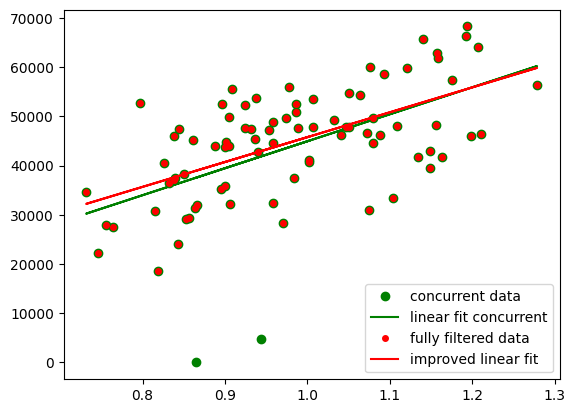

In [21]:
# plot outliers for review

df_filtered = df.loc[df["correlation-outlier"]==False] 

plt.plot(df["windspeed"], df["concurrent-generation-normalised"], 'go', label='concurrent data')
plt.plot(df["windspeed"], df["concurrent-generation-synthesised-with-outliers"], 'g', label='linear fit concurrent')
plt.plot(df["windspeed"], df["concurrent-generation-normalised-filtered"], 'ro', markersize=4, label='fully filtered data')
plt.plot(df["windspeed"], df["concurrent-generation-synthesised"], 'r', label='improved linear fit')
plt.legend()

## Long-term adjustment using Mean of Monthly Means (momm)

The long-term resource adjustment is calculated by comparing the synthesised generation during the concurrent period to the synthesised generation over the long-term. This adjustment is then applied to the actual generation on a monthly basis. This ensures that seasonality is taken into account correctly and that periods excluded from the correlation due, for instance, to misreported availability, are still accounted for in the long-term generation estimates.

Note that the momm availability needs to be calculated from the averaged net and gross generations, as it needs to be energy weighted.

In [22]:
# mean of monthly means
momm = df.groupby("month").mean()

# long-term resource adjustment
momm["resource-adjustment"] = momm["generation-synthesised"]/momm["concurrent-generation-synthesised"]

print(momm[["generation-normalised","generation-synthesised","concurrent-generation-synthesised","resource-adjustment"]])

       generation-normalised  generation-synthesised  \
month                                                  
1               39005.137327            43504.832031   
2               44459.803132            47307.464844   
3               47621.312903            50626.593750   
4               50882.784286            54090.613281   
5               52281.667742            54404.500000   
6               44716.294286            48902.410156   
7               42605.119355            47814.421875   
8               38617.414286            42502.882812   
9               33800.168571            35336.023438   
10              40742.601843            39575.808594   
11              45470.201429            41646.972656   
12              46914.966359            42891.839844   

       concurrent-generation-synthesised  resource-adjustment  
month                                                          
1                           42286.605469             1.028809  
2                      

In [23]:
# long-term monthly
momm["reported-availability"] = momm["generation-filtered"]/momm["gross-generation-filtered"]
momm["gross-generation-long-term"] = momm["gross-generation-filtered"]*momm["resource-adjustment"]
momm["net-generation-long-term"] = momm["gross-generation-long-term"]*momm["reported-availability"]

print(momm[["gross-generation","gross-generation-filtered","resource-adjustment","gross-generation-long-term","reported-availability","net-generation-long-term"]])

       gross-generation  gross-generation-filtered  resource-adjustment  \
month                                                                     
1          40305.308571               40305.308571             1.028809   
2          41997.160000               41997.160000             1.020562   
3          49208.690000               49208.690000             1.022731   
4          50882.784286               50882.784286             1.071642   
5          54024.390000               54024.390000             1.009492   
6          44716.294286               44716.294286             1.091665   
7          44025.290000               44025.290000             0.978750   
8          39904.661429               39904.661429             0.966006   
9          33800.168571               33800.168571             0.959452   
10         42100.688571               42100.688571             1.011390   
11         45470.201429               45470.201429             1.053018   
12         48478.798571  

## Long-term P50 estimate

Having calculated the long-term generation on a monthly basis, this can be summed to provide an annual (P50) estimate of generation. Additional columns are also added to provide more detail regarding the end result.

In [24]:
# P50 estimate
p50 = momm[["generation","gross-generation","gross-generation-filtered","gross-generation-long-term","net-generation-long-term"]].sum()
p50["resource-adjustment"] = p50["gross-generation-long-term"]/p50["gross-generation-filtered"]
p50["availability"] = p50["net-generation-long-term"]/p50["gross-generation-long-term"]
p50["r-squared"] = res.rvalue**2
print(p50)

generation                    534250.435714
gross-generation              534914.435714
gross-generation-filtered     534914.435714
gross-generation-long-term    546022.406275
net-generation-long-term      545344.112737
resource-adjustment                1.020766
availability                       0.998758
r-squared                          0.377262
dtype: float64


## Save results

Finally, the results are saved to excel. This allows a user to re-create the process in excel as required for validation purposes, but also allows this script to be run for multiple plants while keeping the end results available.

In [25]:
# export results to excel

save_pathname = "results"

save_pathname = Path(save_pathname).resolve()

if not save_pathname.exists():
    save_pathname.mkdir()

outfile = save_pathname / f"result_plant_{selected_plant['plantid']}.xlsx"


with pd.ExcelWriter(outfile) as writer:  

    df.sort_index(ascending=False).to_excel(writer, sheet_name='monthly_data')

    momm.to_excel(writer, sheet_name='momm')

    p50.to_excel(writer, sheet_name='p50')

In [26]:
# from sklearn.neighbors import LocalOutlierFactor
# import numpy as np

# clf = LocalOutlierFactor(n_neighbors=2)
# clf.fit_predict(df_concurrent)
# df_concurrent["clf"]=clf.negative_outlier_factor_
# print(df_concurrent)
# df_concurrent.to_clipboard()
#np.mean(np.std(clf.negative_outlier_factor_))-5*np.std(clf.negative_outlier_factor_)

In [27]:

# fig, ax = plt.subplots(figsize=(20,10)) 
# df.plot(y = "generation", ax = ax) 
# df.plot(y = "gross-generation", ax = ax) 
# df.plot(y = "windspeed_ms", ax = ax, secondary_y = True) 
# plt.show()

#fig, ax = plt.subplots(figsize=(20,10)) 
#df.plot.scatter(x="windspeed_ms",y="generation-normalised",ax=ax)


In [28]:
#from sklearn.cluster import DBSCAN

# clustering = DBSCAN(eps=3, min_samples=2).fit(df_concurrent[["windspeed_ms","generation-normalised"]])

# print(clustering.labels_)

In [29]:
# df.columns